In [37]:
library(monocle)

In [26]:
library(dplyr)


Attaching package: ‘dplyr’

The following object is masked from ‘package:Biobase’:

    combine

The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [27]:
library(Matrix)

In [30]:
input='SNARE-seq/ad_imputed_pearsonr/reg_df'

In [31]:
if(file_test("-f", input)){
    cellcount <- read.csv(file = input, row.names = 1, sep='\t')
}else{
    files=list.files(path = input,full.names = TRUE)
    for (f in files){
        if (grepl("count",f)){
            cellcount <- readMM(f)
        } else if (grepl("barcode",f)){
            rna_cells = read.table(f)
        } else if (grepl("peak",f)){
            genes = read.table(f)
        }
    }
colnames(cellcount) <- rna_cells$V1
rownames(cellcount) <- genes$V1
}

In [49]:
colnames(genes)='gene_short_name'
rownames(genes)=genes$gene_short_name
fd <- new("AnnotatedDataFrame", data = genes)
colnames(rna_cells)='barcodes'
rownames(rna_cells)=rna_cells$barcodes
pd <- new("AnnotatedDataFrame", data = rna_cells)

In [164]:
matrix=as.matrix(cellcount)
cds <- newCellDataSet(matrix ,phenoData = pd,featureData = fd)

In [165]:
# filter
cds <- detectGenes(cds, min_expr = 0.1)
print(head(fData(cds)))
expressed_genes <- row.names(subset(fData(cds), num_cells_expressed >= 10))

                                                          gene_short_name
0610040J01Rik_chr5:63648183-63648527 0610040J01Rik_chr5:63648183-63648527
0610040J01Rik_chr5:63649003-63649661 0610040J01Rik_chr5:63649003-63649661
0610040J01Rik_chr5:63652653-63653098 0610040J01Rik_chr5:63652653-63653098
0610040J01Rik_chr5:63811827-63812817 0610040J01Rik_chr5:63811827-63812817
0610040J01Rik_chr5:63968522-63969285 0610040J01Rik_chr5:63968522-63969285
0610040J01Rik_chr5:64044841-64045258 0610040J01Rik_chr5:64044841-64045258
                                     num_cells_expressed
0610040J01Rik_chr5:63648183-63648527                 209
0610040J01Rik_chr5:63649003-63649661                 201
0610040J01Rik_chr5:63652653-63653098                 188
0610040J01Rik_chr5:63811827-63812817                 219
0610040J01Rik_chr5:63968522-63969285                 262
0610040J01Rik_chr5:64044841-64045258                 245


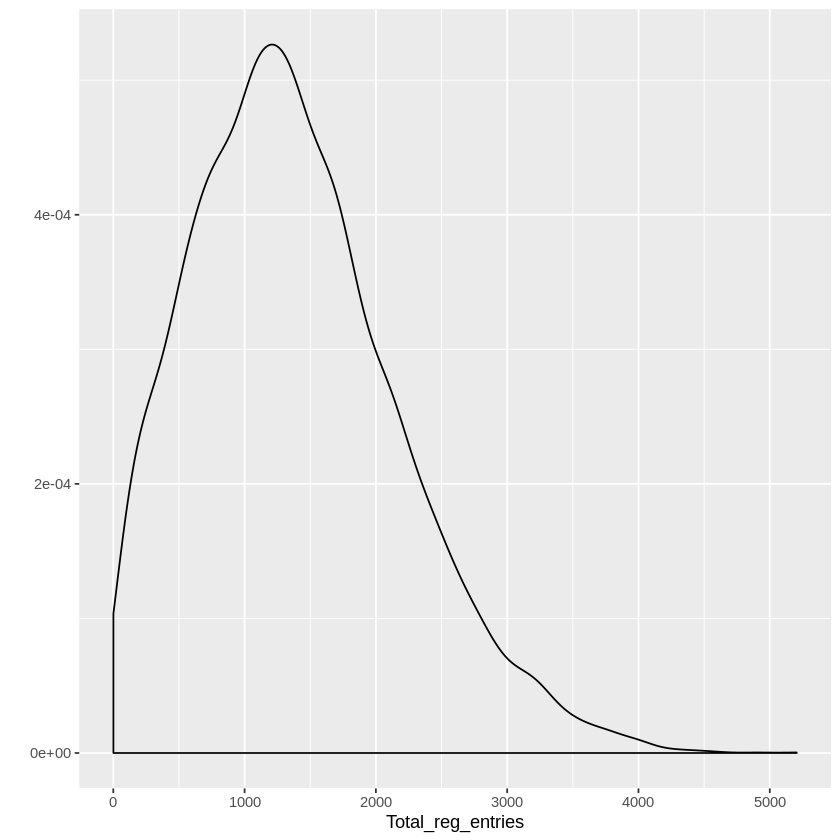

In [166]:
pData(cds)$Total_reg_entries <- Matrix::colSums(exprs(cds))

#cds <- cds[,pData(cds)$Total_reg_entries < 1e6]

#upper_bound <- mean(pData(cds)$Total_reg_entries) + 2*sd(pData(cds)$Total_reg_entries)
#lower_bound <- mean(pData(cds)$Total_reg_entries) - 2*sd(pData(cds)$Total_reg_entries)

qplot(Total_reg_entries, data = pData(cds),  geom = "density") #+ 
#    geom_vline(xintercept = lower_bound) + 
#    geom_vline(xintercept = upper_bound)

In [87]:
cds.copy <- cds

In [167]:
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds)

Removing 115 outliers


Warning message:
“Transformation introduced infinite values in continuous y-axis”Warning message:
“Transformation introduced infinite values in continuous y-axis”

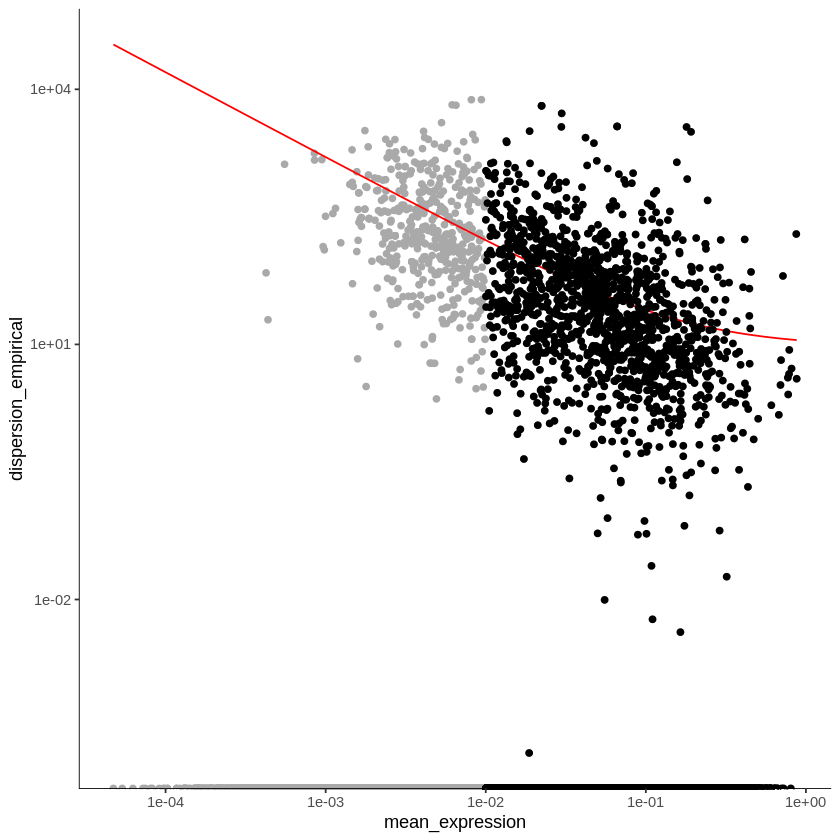

In [168]:
disp_table <- dispersionTable(cds)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.01)
cds <- setOrderingFilter(cds, unsup_clustering_genes$gene_id)
plot_ordering_genes(cds)

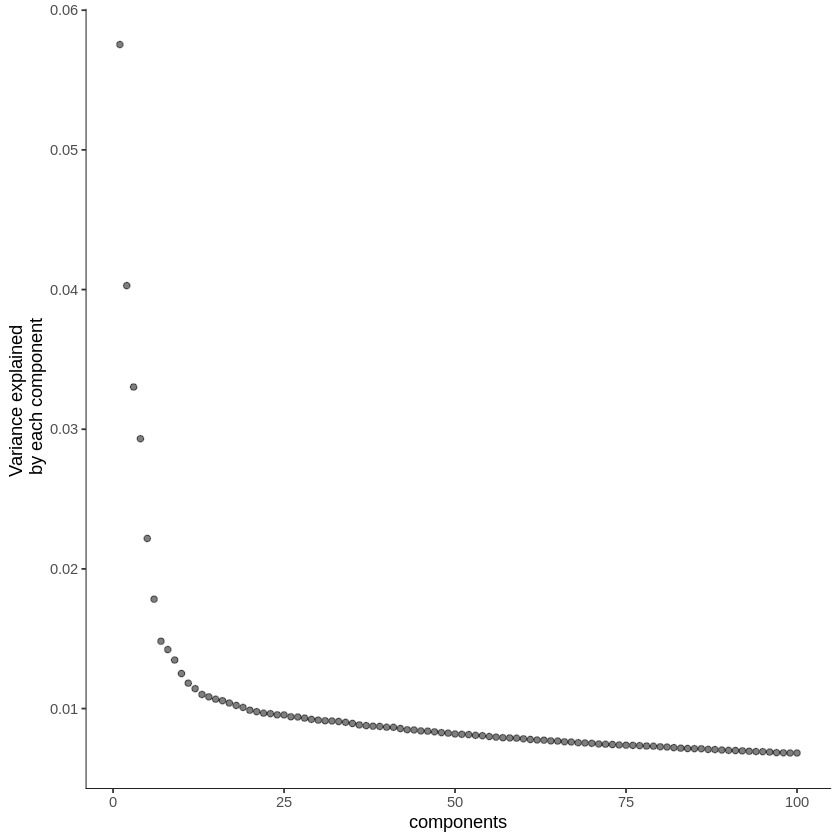

In [169]:
plot_pc_variance_explained(cds, return_all = F) # norm_method='log'

Remove noise by PCA ...
Reduce dimension by tSNE ...


Distance cutoff calculated to 4.164045 


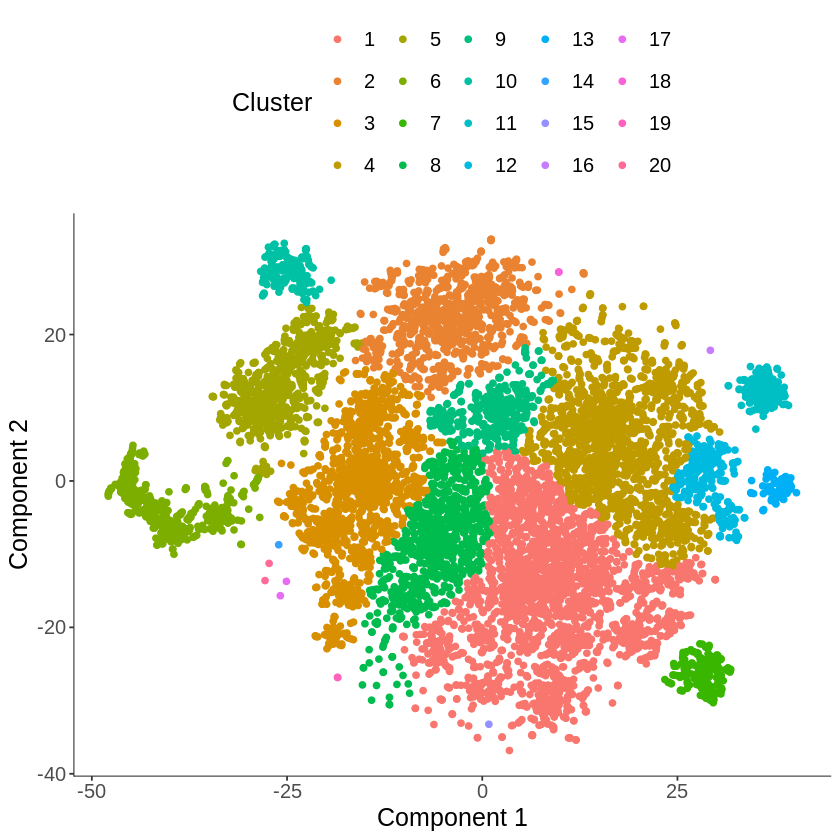

In [170]:
cds <- reduceDimension(cds, max_components = 2, num_dim = 50,
                reduction_method = 'tSNE', verbose = T)
cds <- clusterCells(cds, num_clusters = 20)
plot_cell_clusters(cds, 1, 2, color = "Cluster")

In [99]:
clustering_DEG_genes <-
    differentialGeneTest(cds[expressed_genes,],
          fullModelFormulaStr = '~Cluster',
          cores = 1)

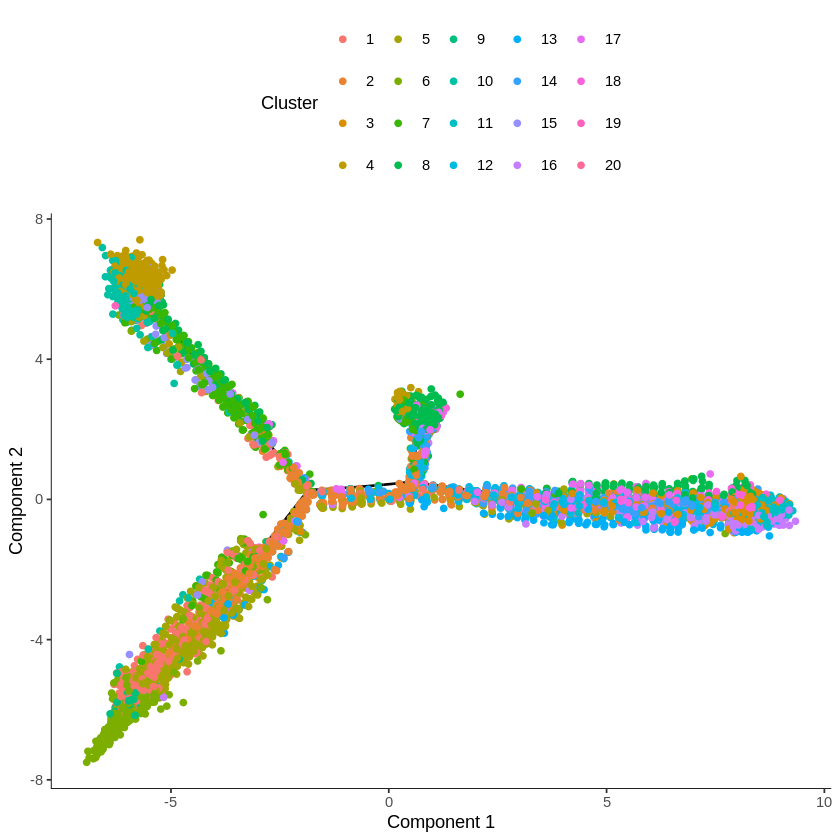

In [100]:
ordering_genes <-row.names(clustering_DEG_genes)[order(clustering_DEG_genes$qval)][1:1000]

cds <-setOrderingFilter(cds,
        ordering_genes = ordering_genes)

cds <-reduceDimension(cds, method = 'DDRTree')

cds <-orderCells(cds)

plot_cell_trajectory(cds, color_by = "Cluster")

In [137]:
cds <- csd

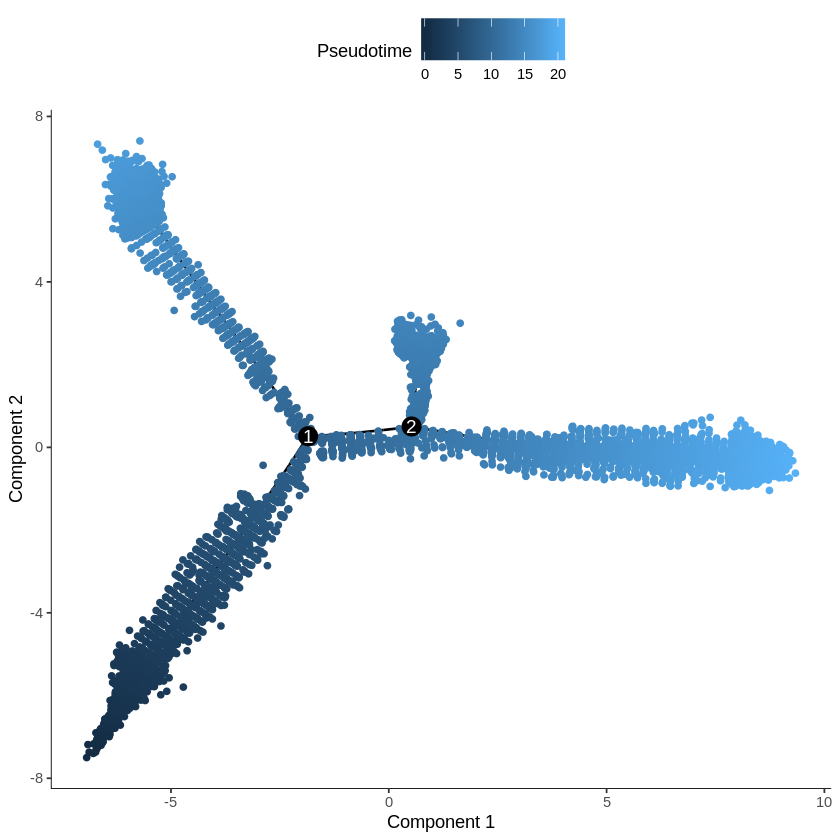

In [136]:
plot_cell_trajectory(cds, color_by = "Pseudotime")

In [102]:
BEAM_res <- BEAM(cds, branch_point = 1, cores = 1)
BEAM_res <- BEAM_res[order(BEAM_res$qval),]
BEAM_res <- BEAM_res[,c("gene_short_name", "pval", "qval")]

Warning message in if (progenitor_method == "duplicate") {:
“the condition has length > 1 and only the first element will be used”Warning message in if (progenitor_method == "sequential_split") {:
“the condition has length > 1 and only the first element will be used”

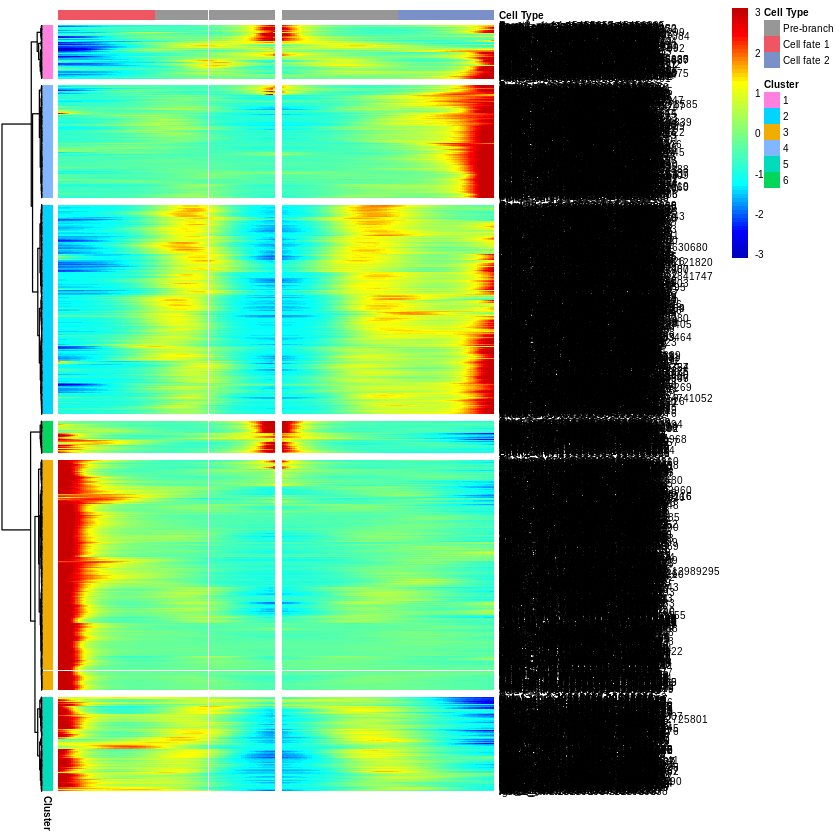

In [106]:
plot_genes_branched_heatmap(csd[row.names(subset(BEAM_res,
                                          qval < 1e-6)),],
                                          branch_point = 1,
                                          num_clusters = 6,
                                          cores = 1,
                                          use_gene_short_name = T,
                                          show_rownames = T)

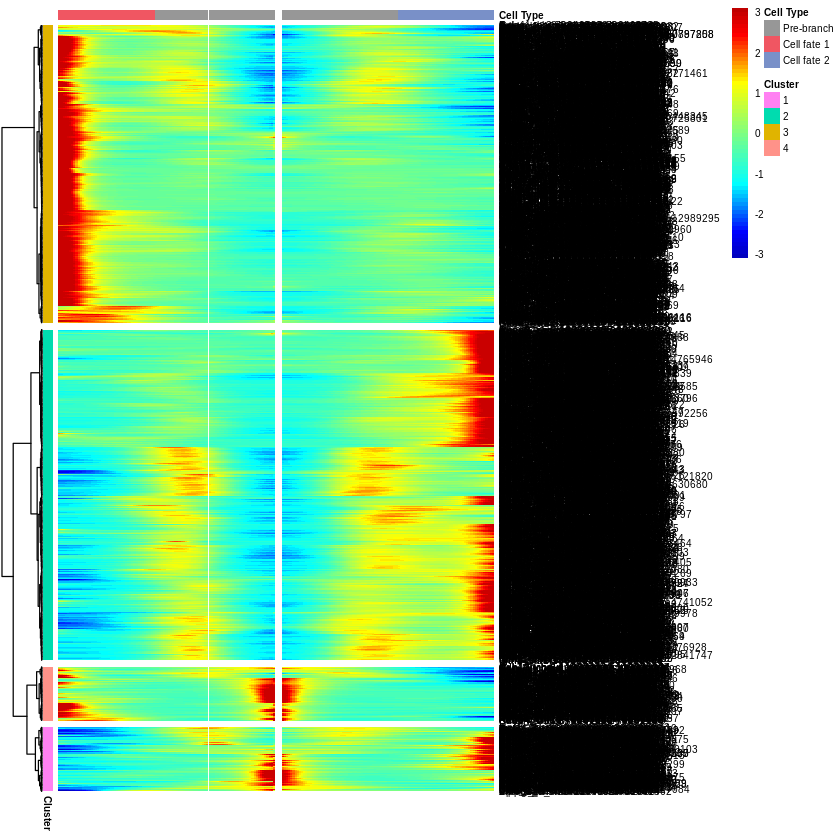

In [104]:
plot_genes_branched_heatmap(csd[row.names(subset(BEAM_res,
                                          qval < 1e-4)),],
                                          branch_point = 1,
                                          num_clusters = 4,
                                          cores = 1,
                                          use_gene_short_name = T,
                                          show_rownames = T)

In [107]:
print(head(pData(cds)))

                         barcodes Size_Factor num_genes_expressed
09C_CTAGTACACCAG 09C_CTAGTACACCAG   1.7126880                1875
09G_GTAAAAGAGGGA 09G_GTAAAAGAGGGA   1.2989026                1422
09L_AGGGACCCAGAT 09L_AGGGACCCAGAT   1.5016848                1644
09F_CGTAACGTGTAT 09F_CGTAACGTGTAT   0.6202214                 679
09G_CTATGGACACAC 09G_CTATGGACACAC   0.4804661                 526
09E_ACACACCCGGAA 09E_ACACACCCGGAA   0.8988187                 984
                 Total_reg_entries Cluster peaks halo      delta       rho
09C_CTAGTACACCAG              1875       8 FALSE TRUE 0.04042779 134.81489
09G_GTAAAAGAGGGA              1422      12 FALSE TRUE 0.44715655 174.59345
09L_AGGGACCCAGAT              1644       3 FALSE TRUE 1.43847719 144.77649
09F_CGTAACGTGTAT               679      13 FALSE TRUE 0.92568815  98.06306
09G_CTATGGACACAC               526      13 FALSE TRUE 0.21183083 132.65842
09E_ACACACCCGGAA               984       6 FALSE TRUE 0.10852990 149.13582
             

In [171]:
cell_type=read.table('SNARE-seq/ad_scanpy/cluster.txt', header = F, row.names = 1)
cds_cell_type=cell_type[pData(cds)$barcodes, ]

In [172]:
new_cds=cds
pData(new_cds)$cell_type=cds_cell_type

In [159]:
head(pData(new_cds))

,barcodes,Size_Factor,num_genes_expressed,Total_reg_entries,Cluster,peaks,halo,delta,rho,nearest_higher_density_neighbor,Pseudotime,State,cell_type
,<fct>,<dbl>,<dbl>,<dbl>,<fct>,<lgl>,<lgl>,<dbl>,<dbl>,<lgl>,<dbl>,<fct>,<fct>
09C_CTAGTACACCAG,09C_CTAGTACACCAG,1.7126880,1875,1875,8,FALSE,TRUE,0.04042779,134.81489,NA,13.641593,4,Slit3
09G_GTAAAAGAGGGA,09G_GTAAAAGAGGGA,1.2989026,1422,1422,12,FALSE,TRUE,0.44715655,174.59345,NA,13.375463,5,Slit3
09L_AGGGACCCAGAT,09L_AGGGACCCAGAT,1.5016848,1644,1644,3,FALSE,TRUE,1.43847719,144.77649,NA,19.119442,5,Ex-L3/4–Rorb
09F_CGTAACGTGTAT,09F_CGTAACGTGTAT,0.6202214,679,679,13,FALSE,TRUE,0.92568815,98.06306,NA,17.409331,5,Cdh18
09G_CTATGGACACAC,09G_CTATGGACACAC,0.4804661,526,526,13,FALSE,TRUE,0.21183083,132.65842,NA,15.159074,5,Slit3
09E_ACACACCCGGAA,09E_ACACACCCGGAA,0.8988187,984,984,6,FALSE,TRUE,0.10852990,149.13582,NA,1.470008,1,Ex-L4/5–Il1rapl2


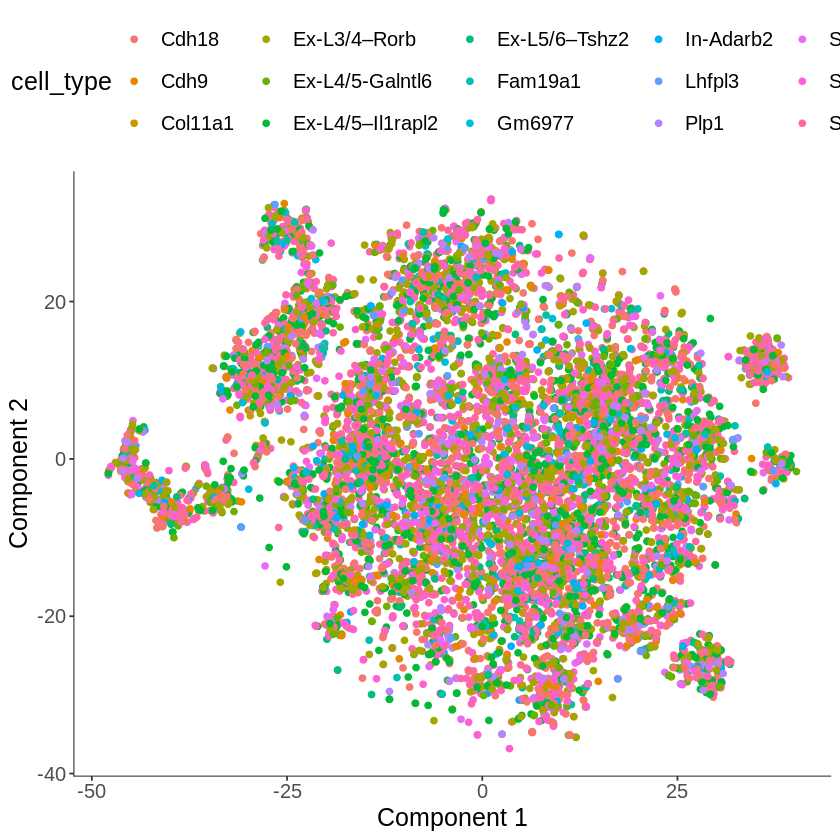

In [173]:
plot_cell_clusters(new_cds, 1, 2, color = "cell_type")

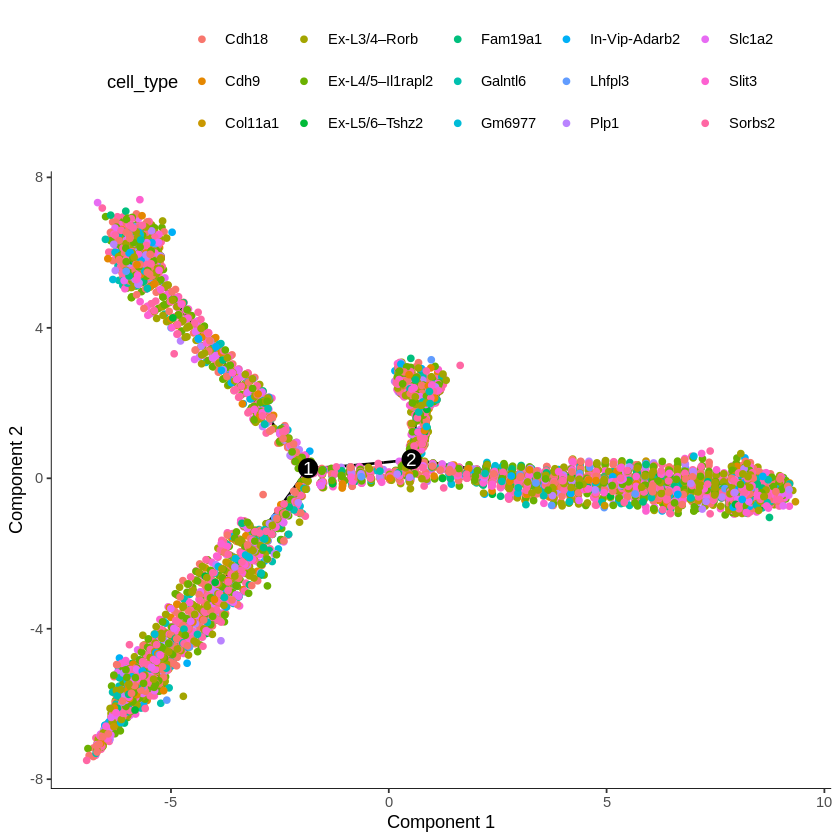

In [161]:
plot_cell_trajectory(new_cds, color_by = "cell_type")

In [174]:
seurat <- exportCDS(new_cds, export_to = "Scater")
saveRDS(seurat, file='SNARE-seq/ad_imputed_pearsonr/monocle.rds')

Loading required namespace: scater


ERROR: Error: 'newSCESet' is not an exported object from 'namespace:scater'
